<a href="https://www.lsce.ipsl.fr">
 <img src="https://www.lsce.ipsl.fr/wp-content/uploads/2023/12/Logo_LSCE_Horizontal_SR.jpg" width="200" />
</a>

<a href="https://www.ipsl.fr">
 <img src="https://www.ipsl.fr/wp-content/themes/ipsltheme/themes/logo/logo_ipsl_2.png" width="80px"/>
</a>

# Plotting ORCA outputs with `cartopy` and `matplotlib`

**A gallery of plots with the curvilinear ORCA Grid**

# Stuff

## Licence

This software is governed by the [CeCILL license](http://www.cecill.info) license under French law and abiding by the rules of distribution of free software. You can use, modify and/ or redistribute the software under the terms of the [CeCILL license](http://www.cecill.info) as circulated by CEA, CNRS and INRIA.

Warning, to install, configure, run, use any of Olivier Marti's software or to read the associated documentation you'll need at least one (1) brain in a reasonably working order. Lack of this implement will void any warranties (either express or implied). O. Marti assumes no responsability for errors, omissions, data loss, or any other consequences caused directly or indirectly by the usage of his software by incorrectly or partially configured personal. Please be aware that the author himself may not respect the prerequisites.


## Contact

<a href="https://www.lsce.ipsl.fr/en/pisp/olivier-marti">
    <img src="https://owncloud.dedikam.com/index.php/apps/files_sharing/publicpreview/s2jpzciWbEBe3qH?file=/&fileId=555030481&x=2560&y=1440&a=true&etag=6d24d6bdd56352e944ab74b8a8a8129a" width="100px">  
    </a>

mailto:olivier.marti@lsce.ipsl.fr 

## GitHub
<https://github.com/oliviermarti/IPSLCM-Utilities>

# Initialize

## Needed python modules

### 'Classic' modules

In [1]:
import importlib
import sys
import os
from typing import reveal_type 
import numpy as np
import cftime
import xarray as xr
import pandas as pd
import xcdat as xc
import xgcm 

import shapely as shp
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.mpl.ticker
import cartopy.crs as ccrs
import cartopy

print ( f'Version python     : {sys.version}'    )
print ( f'Version numpy      : {np.__version__}' )
print ( f'Version xarray     : {xr.__version__}' )
print ( f'Source xarray      : {xr.__file__}'    )
print ( f'Version pandas     : {pd.__version__}' )
print ( f'Version xcdat      : {xc.__version__}' )
print ( f'Version Matplotlib : {mpl.__version__}'     )
print ( f'Version Cartopy    : {cartopy.__version__}' )

use_xgcm=True
  
np.set_printoptions (precision=1, floatmode='fixed')

Version python     : 3.13.5 | packaged by conda-forge | (main, Jun 16 2025, 08:24:05) [Clang 18.1.8 ]
Version numpy      : 2.2.6
Version xarray     : 2025.7.1
Source xarray      : /Users/marti/miniforge3/envs/PROD/lib/python3.13/site-packages/xarray/__init__.py
Version pandas     : 2.3.0
Version xcdat      : 0.9.1
Version Matplotlib : 3.10.3
Version Cartopy    : 0.25.0


### Specific module to simplify access to IPSL model outputs

In [2]:
import libIGCM
import plotIGCM

## A specific module to handle ORCA grid particularisms

Use `help(nemo)` to get some details

In [3]:
from plotIGCM import nemo
importlib.reload (nemo)
print ( f'{nemo.__file__ = }' )

nemo.__file__ = '/Users/marti/Python/Library/plotIGCM/nemo.py'


## A module with IPCC color palettes

In [4]:
import IPCC

## Earth Radius

In [5]:
Ra = nemo.RA
print (Ra)

<xarray.DataArray 'RA' ()> Size: 8B
array(6371229.0)
Attributes:
    units:      meter
    long_name:  Earth radius


# Read and prepare data

## Using ORCA1 or ORCA2

Use only one of the following cells, and comment the others (switch them to `Raw Text` to make them inactive)

In [6]:
cfg_name = "eorca1.2"
mm = libIGCM.sys.Config (JobName='IPSLCM6.2-ECS-LR-W3-181', TagName='IPSLCM6', ExperimentName='piControl', SpaceName='PROD',
                        ) # Source='TGCC_thredds', TGCC_User='p86caub', TGCC_Group='gencmip6' )

mm.Dir    = os.path.join ( mm.R_SAVE, 'OCE', 'Analyse', 'SE' )
mm.Period = 'SE_2090_2099_1M'
time_sel = { 'time_counter':slice (None, None) }
domain = nemo.Domain (cfg_name=cfg_name)
btype='lbc'

In [7]:
cfg_name = domain.cfg_name

### Utilities

In [8]:
def GetFile (url, File=None) : 
    from urllib.request import urlretrieve
    from pathlib import Path
    if File : File = Path (File)
    else    : File = Path (os.path.basename(url))
    if not File.exists () : urlretrieve (url, File)
    return File

## Defines files names

In [9]:
f_T = os.path.join (mm.Dir, f'{mm.JobName}_{mm.Period}_grid_T.nc' )
f_U = os.path.join (mm.Dir, f'{mm.JobName}_{mm.Period}_grid_U.nc' )
f_V = os.path.join (mm.Dir, f'{mm.JobName}_{mm.Period}_grid_V.nc' )
f_W = os.path.join (mm.Dir, f'{mm.JobName}_{mm.Period}_grid_W.nc' )

f_g  = os.path.join (mm.R_IN, 'OCE', 'NEMO', domain.CFG_name, 'GRIDS', f'{domain.CFG_name}_coordinates_mask.nc'  )
f_e  = os.path.join (mm.R_IN, 'OCE', 'NEMO', domain.CFG_name, 'GRIDS', f'{domain.CFG_name}_coordinates.nc'  )
f_d  = os.path.join (mm.R_IN, 'OCE', 'NEMO', domain.CFG_name, 'GRIDS', f'{domain.CFG_name}_domcfg.nc'  )
f_b  = os.path.join (mm.DB, 'extras', f'{domain.CFG_name}_subbasins.nc'   )
f_s  = os.path.join (mm.DB, 'extras', f'{domain.cfg_name}_coastline.json' )
f_l  = os.path.join (mm.DB, 'extras', f'{domain.cfg_name}_land.json' )
f_gl = os.path.join (mm.DB, 'extras', f'{domain.cfg_name}_gridlines.json' )



if domain.cfg_name in ['eorca1.2', 'eorca1.4.0'] :
    f_g = os.path.join (mm.R_IN, 'OCE', 'NEMO', 'eORCA1.4.0', 'GRIDS', 'eORCA1.2_coordinates_mask.nc'  )
    f_e = os.path.join (mm.R_IN, 'OCE', 'NEMO', 'eORCA1.4.0', 'GRIDS', 'eORCA1.2_coordinates.nc'  )
    f_d = os.path.join (mm.R_IN, 'OCE', 'NEMO', 'eORCA1.4.0', 'GRIDS', 'eORCA1_domain_cfg.nc'  )

if domain.cfg_name in ['orca2.3' ] :
    f_g = os.path.join (mm.R_GRAF, 'ORCA2.3_mesh_mask.nc'  )

f_s  = libIGCM.sys.Dap2Thredds (f_s , mm)
f_l  = libIGCM.sys.Dap2Thredds (f_l , mm)
f_gl = libIGCM.sys.Dap2Thredds (f_gl, mm)

print (f'{f_g  = }')
print (f'{f_e  = }')
print (f'{f_d  = }')
print (f'{f_b  = }')
print (f'{f_T  = }')
print (f'{f_U  = }')
print (f'{f_V  = }')
print (f'{f_W  = }')
print (f'{f_s  = }')
print (f'{f_l  = }')
print (f'{f_gl = }')

f_g  = '/Users/marti/Data/IGCM/OCE/NEMO/eORCA1.4.0/GRIDS/eORCA1.2_coordinates_mask.nc'
f_e  = '/Users/marti/Data/IGCM/OCE/NEMO/eORCA1.4.0/GRIDS/eORCA1.2_coordinates.nc'
f_d  = '/Users/marti/Data/IGCM/OCE/NEMO/eORCA1.4.0/GRIDS/eORCA1_domain_cfg.nc'
f_b  = '/Users/marti/Data/database/extras/eORCA1.2_subbasins.nc'
f_T  = '/Users/marti/Data/IGCM_OUT/IPSLCM6/PROD/piControl/IPSLCM6.2-ECS-LR-W3-181/OCE/Analyse/SE/IPSLCM6.2-ECS-LR-W3-181_SE_2090_2099_1M_grid_T.nc'
f_U  = '/Users/marti/Data/IGCM_OUT/IPSLCM6/PROD/piControl/IPSLCM6.2-ECS-LR-W3-181/OCE/Analyse/SE/IPSLCM6.2-ECS-LR-W3-181_SE_2090_2099_1M_grid_U.nc'
f_V  = '/Users/marti/Data/IGCM_OUT/IPSLCM6/PROD/piControl/IPSLCM6.2-ECS-LR-W3-181/OCE/Analyse/SE/IPSLCM6.2-ECS-LR-W3-181_SE_2090_2099_1M_grid_V.nc'
f_W  = '/Users/marti/Data/IGCM_OUT/IPSLCM6/PROD/piControl/IPSLCM6.2-ECS-LR-W3-181/OCE/Analyse/SE/IPSLCM6.2-ECS-LR-W3-181_SE_2090_2099_1M_grid_W.nc'
f_s  = '/Users/marti/Data/database/extras/eorca1.2_coastline.json'
f_l  = '/Users/marti/Data/da

## Open files

In [10]:
kw = {'decode_times':False}

d_g = xc.open_dataset (f_g, **kw).squeeze () if os.path.isfile (f_g) else None
d_e = xc.open_dataset (f_e, **kw).squeeze () if os.path.isfile (f_e) else None
d_d = xc.open_dataset (f_d, **kw).squeeze () if os.path.isfile (f_d) else None
d_b = xc.open_dataset (f_b, **kw).squeeze () if os.path.isfile (f_b) else None

In [11]:
time_coder = xr.coders.CFDatetimeCoder (use_cftime=True)
kw = {'use_cftime':True, 'decode_cf':True, 'decode_times':time_coder}

d_T = xc.open_dataset (f_T, **kw)[time_sel] 
d_U = xc.open_dataset (f_U, **kw)[time_sel]
d_V = xc.open_dataset (f_V, **kw)[time_sel]
d_W = xc.open_dataset (f_W, **kw)[time_sel]

### Use a fixed name for all dimensions to simplify the rest of the notebook
Not depending of the dataset used, the model version, etc ...

In [12]:
importlib.reload (nemo)
udims = nemo.UDIMS
if use_xgcm :
    kw_uni = {'use_xgcm':use_xgcm}
kw_uni.update (udims)

d_T = nemo.unify_dims (d_T, **kw_uni, xgrid='T')
d_U = nemo.unify_dims (d_U, **kw_uni, xgrid='U')
d_V = nemo.unify_dims (d_V, **kw_uni, xgrid='V')
d_W = nemo.unify_dims (d_W, **kw_uni, xgrid='W')
d_g = nemo.unify_dims (d_g, **kw_uni, xgrid='T')
d_e = nemo.unify_dims (d_e, **kw_uni, xgrid='T')
d_d = nemo.unify_dims (d_d, **kw_uni, xgrid='T')
d_b = nemo.unify_dims (d_b, **kw_uni)

## Read variables

In [13]:
importlib.reload (nemo) ; domain = nemo.Domain(**domain)
domain = nemo.Domain (ptab=d_T.thetao, domain=domain)
jpi=domain.jpi ; jpj=domain.jpj ; jpk=domain.jpk #; aperio=domain.aperio

kw={'cd_type':'T', 'domain':domain, 'btype':btype}
thetao = nemo.lbcu (d_T.thetao   , **kw, **kw_uni)
so     = nemo.lbcu (d_T.so       , **kw, **kw_uni)
rhop   = nemo.lbcu (d_T.rhopoto  , **kw, **kw_uni)
rhop.name = 'rhop'
lon    = nemo.lbcu (d_T.nav_lon_T, **kw, **kw_uni)
lat    = nemo.lbcu (d_T.nav_lat_T, **kw, **kw_uni)
depthT = nemo.lbcu (d_T ['z_c']  , **kw, **kw_uni)

jeq = nemo.jeq (lat) # Index of equator

In [14]:
# Needed for eORCA1.4.2 with missing lon and lat values
lat, lon = nemo.fill_latlon (lat, lon, sval=-1)

In [15]:
lon = nemo.fixed_lon(lon)

In [16]:
kw = {'domain':domain, 'btype':btype}
uo   = nemo.lbcu (d_U.uo       , **kw_uni, **kw, cd_type='U', psgn=-1)
lonU = nemo.lbcu (d_U.nav_lon_U, **kw_uni, **kw, cd_type='U', psgn= 1)
latU = nemo.lbcu (d_U.nav_lat_U, **kw_uni, **kw, cd_type='U', psgn= 1)
vo   = nemo.lbcu (d_V.vo       , **kw_uni, **kw, cd_type='V', psgn=-1)
lonV = nemo.lbcu (d_V.nav_lon_V, **kw_uni, **kw, cd_type='V', psgn= 1)
latV = nemo.lbcu (d_V.nav_lat_V, **kw_uni, **kw, cd_type='V', psgn= 1)
wo   = nemo.lbcu (d_W.wo       , **kw_uni, **kw, cd_type='W', psgn= 1)
depthW = d_W ['z_f']

## Lecture des facteurs des métriques

### Horizontales

In [17]:
importlib.reload(nemo) ; domain = nemo.Domain (**domain)

kw = {'domain':domain, 'btype':btype, 'psgn':1}
if 'e1t' in d_g.variables : 
    e1t  = nemo.lbcu (d_g.e1t, **kw_uni, **kw, cd_type='T')
    e2t  = nemo.lbcu (d_g.e2t, **kw_uni, **kw, cd_type='T')
    e1u  = nemo.lbcu (d_g.e1u, **kw_uni, **kw, cd_type='U')
    e1v  = nemo.lbcu (d_g.e1v, **kw_uni, **kw, cd_type='V')
    e2u  = nemo.lbcu (d_g.e2u, **kw_uni, **kw ,cd_type='U')
    e2v  = nemo.lbcu (d_g.e2v, **kw_uni, **kw, cd_type='V')
    e1f  = nemo.lbcu (d_g.e1f, **kw_uni, **kw, cd_type='F')
    e2f  = nemo.lbcu (d_g.e2f, **kw_uni, **kw, cd_type='F')
else :
    e1t  = nemo.lbcu (d_d.e1t, **kw_uni, **kw, cd_type='T')
    e2t  = nemo.lbcu (d_d.e2t, **kw_uni, **kw, cd_type='T')
    e1u  = nemo.lbcu (d_d.e1u, **kw_uni, **kw, cd_type='U')
    e1v  = nemo.lbcu (d_d.e1v, **kw_uni, **kw, cd_type='V')
    e2u  = nemo.lbcu (d_d.e2u, **kw_uni, **kw, cd_type='U')
    e2v  = nemo.lbcu (d_d.e2v, **kw_uni, **kw, cd_type='V')
    e1f  = nemo.lbcu (d_d.e1f, **kw_uni, **kw, cd_type='F')
    e2f  = nemo.lbcu (d_d.e2f, **kw_uni, **kw, cd_type='F')

### Verticales

In [18]:
kw = {'domain':domain, 'btype':btype, 'psgn':1}
e3t  = nemo.lbcu (d_T.e3t, **kw_uni, **kw ,cd_type='T')
e3u  = nemo.lbcu (d_U.e3u, **kw_uni, **kw, cd_type='U')
e3v  = nemo.lbcu (d_V.e3v, **kw_uni, **kw, cd_type='V')
e3w  = nemo.lbcu (d_W.e3w, **kw_uni, **kw, cd_type='W')
e3f  = nemo.lbcu (d_T.e3t, **kw_uni, **kw, cd_type='F')

areat = e1t*e2t
areau = e1u*e2u
areav = e1v*e2v
areaf = e1f*e2f

bt = areat*e3t
bu = areau*e3u
bv = areav*e3v
bf = areaf*e3f

## d_grid for some vertical interpolations

In [19]:
importlib.reload(nemo) ; domain=nemo.Domain(**domain)
d_grid  = xr.Dataset ( {'e1t':e1t, 'e1u':e1u, 'e1v':e1v, 'e1f':e1f,
                        'e2t':e2t, 'e2u':e2u, 'e2v':e2v, 'e2f':e2f,
                        'e3t':e3t, 'e3u':e3u, 'e3v':e3v, 'e3f':e3f, 'e3w':e3w,
                        'areat':areat, 'areau':areau, 'areav':areav, 'areaf':areaf,
                        'z_c_bnds1d': nemo.build_bounds1d (d_T.z_c_bounds)} )

In [20]:
grid = xgcm.Grid (d_grid,
        coords={"X": {"center": "x_c", "left": "x_f"}, 
                "Y": {"center": "y_c", "left": "y_f"}, 
                "Z": {"center": "z_c", "left":"z_f", "outer": "z_c_bnds1d"}},
        metrics={
            ("X",): ["e1t", "e1u", "e1v", "e1f"],
            ("Y",): ["e2t", "e2u", "e2v", "e2f"],
            ("Z",): ["e3t", "e3u", "e3v", "e3w"],
            ('X', 'Y'): ['areat', 'areau', 'areav', 'areaf']
        },
        periodic=False, )

### Masks

In [22]:
tmask = xr.where (d_T.so.isel({udims['t']:0})>-1, 1, np.nan)
tmask.name = 'tmask'
tmask = nemo.lbcu (tmask, **kw_uni, domain=domain, cd_type='T', psgn=1, btype=btype)
umask = nemo.t2u (tmask, action='mult', domain=domain)
umask = nemo.lbcu (umask, **kw_uni, domain=domain, cd_type='U', psgn=1, btype=btype)
vmask = nemo.t2v (tmask, action='mult', domain=domain)
vmask = nemo.lbcu (vmask, **kw_uni, domain=domain, cd_type='V', psgn=1, btype=btype)
fmask = nemo.u2f (umask, action='mult', domain=domain)
fmask = nemo.lbcu (fmask, **kw_uni, domain=domain, cd_type='F', psgn=1, btype=btype)

mask  = tmask.isel ({'z_c':0})

# Coastline
# f_s should be on the local file system. OpenDAP reading not available for json files
if 'http' in f_s : d_s = open (GetFile (f_s), 'r')
else             : d_s = open (f_s, 'r')
coast_shp  = shp.from_geojson (d_s.read())
coast_poly = cartopy.feature.ShapelyFeature (coast_shp, ccrs.PlateCarree(), facecolor='none', edgecolor='k')
d_s.close()

if 'http' in f_l : d_l = open (GetFile (f_l), 'r')
else             : d_l = open (f_l, 'r')
land_shp  = shp.from_geojson (d_l.read())
land_poly = cartopy.feature.ShapelyFeature (land_shp, ccrs.PlateCarree(), facecolor='grey', edgecolor='none')
d_l.close()

if 'http' in f_gl : d_gl = open (GetFile (f_gl), 'r')
else              : d_gl = open (f_gl, 'r')
grid_shp  = shp.from_geojson (d_gl.read())
grid_poly = cartopy.feature.ShapelyFeature (grid_shp, ccrs.PlateCarree(), facecolor='grey', edgecolor='none')
d_gl.close()

# Oceanic basin mask
kw = {'domain':domain, 'psgn':1, 'cd_type':'T', 'btype':btype}
atlmsk = nemo.lbcu (d_b.atlmsk, **kw_uni, **kw)
pacmsk = nemo.lbcu (d_b.pacmsk, **kw_uni, **kw)
indmsk = nemo.lbcu (d_b.indmsk, **kw_uni, **kw)

try    : atlmsk_nomed = nemo.lbcu (d_b.atlmsk_nomed, **kw_uni, **kw)
except : atlmsk_nomed = None

ipcmsk = np.clip (pacmsk + indmsk, 0, 1)

lat1D, lon1D = nemo.latlon1d (lat, lon)

### Create a mask for plotting land masses in vertical sections

In [23]:
land = xr.where (np.isnan (thetao[{udims['t']:0}]), 1.0, np.nan)

## Corrects data and metadata for nice plots

### Corrects longitudes

Near the north pole

In [24]:
lon  = nemo.fixed_lon (lon )
lonU = nemo.fixed_lon (lonU)
lonV = nemo.fixed_lon (lonV)

### Force correct periodicity and north pole folding

In [25]:
#%%time
#thetao = nemo.lbc (thetao, domain=domain, cd_type='T', psgn= 1)
#so     = nemo.lbc (so    , domain=domain, cd_type='T', psgn= 1)
#uo     = nemo.lbc (uo    , domain=domain, cd_type='U', psgn=-1)
#vo     = nemo.lbc (vo    , domain=domain, cd_type='V', psgn=-1)
#wo     = nemo.lbc (wo    , domain=domain, cd_type='T', psgn= 1)

### Style and font size for plots

In [26]:
#plt.style.use ("dark_background")
plt.rcParams ['font.size'] = '16'

background = plt.rcParams['figure.facecolor']
foreground = plt.rcParams['lines.color']

### Get logo files

In [27]:
def GetLogo (url, File='Logo.png', Debug=False) : 
    import requests
    import os
    from pathlib import Path
    Logo = None
    if File : 
        File = Path (File)
    else : 
        File = Path (os.path.basename(url))
    if Debug : print ( f'Found {File=}')

    if "http" in url : 
        suffix = File.suffix
        if suffix == '' : 
            suffix = '.png'
            File = File + suffix
        if not File.exists () :
            try : 
                if Debug : print (f'request {url=}')
                data = requests.get(url).content
            except Exception as e : 
                if Debug : print ( f'{e=}')
                Logo = None
            else : 
                if Debug : print ( f'open {File=}')
                file = open ( f'{File}', 'wb')
                file.write (data)
                Logo = mpl.image.imread ( f'{File}')
    else :
        Logo = mpl.image.imread (url)
    return Logo

In [28]:
LogoIPSL = GetLogo ( "https://www.archives.ipsl.fr/extension/design_ipsl/design/standard/images/logo_ipsl.png", 'Logo_IPSL.png')
LogoNEMO = GetLogo ( "https://www.nemo-ocean.eu/doc/img107.png", 'Logo_NEMO.png', Debug=False )

# Plots

## Using `find_ji`
Utility to find index for a given position

### T/S diagram at single point

pp={'y_c': <xarray.DataArray ()> Size: 8B
array(273), 'x_c': <xarray.DataArray ()> Size: 8B
array(258)}
lat.isel (pp)=<xarray.DataArray 'nav_lat_T' ()> Size: 4B
array(59.7, dtype=float32)
Coordinates:
    nav_lat_T  float32 4B 59.71
    nav_lon_T  float32 4B -29.87
    x_c        int64 8B 259
    y_c        int64 8B 274 , lon.isel (pp)+360=<xarray.DataArray 'nav_lon_T' ()> Size: 4B
array(330.1, dtype=float32)
Coordinates:
    nav_lat_T  float32 4B 59.71
    nav_lon_T  float32 4B -29.87
    x_c        int64 8B 259
    y_c        int64 8B 274
xx=(np.float64(32.22949981689453), np.float64(34.995025634765625)) yy=(np.float64(0.1518167659640312), np.float64(5.3780808940529825))


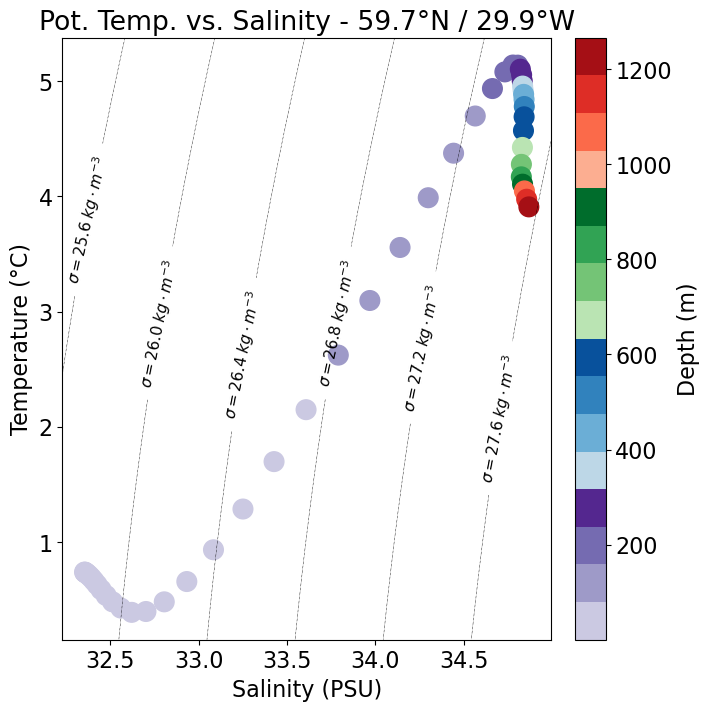

In [29]:
# Set lat/lon 
lat_data = 60. ; lon_data = -30.

pp = nemo.find_ji (lat_data, lon_data, lat, lon, out='dict')
fig, ax = plt.subplots ( figsize=(7,7), layout="constrained" )

# plot T/S values
print ( f'{pp=}' )
print ( f'{lat.isel (pp)=} , {lon.isel (pp)+360=}' )

tt = thetao.isel (pp).mean (dim='time_counter')
ss = so.isel     (pp).mean (dim='time_counter')
zz = ss.z_c

msca = ax.scatter (ss, tt, marker='o', s=200, c=zz, cmap=IPCC.cmap.MultiCat_4)
ax.set_xlabel ('Salinity (PSU)')
ax.set_ylabel ('Temperature (°C)')

xx = ax.get_xlim () ; yy = ax.get_ylim ()

print ( f'{xx=} {yy=}' )

# Plot rho isolines in background
Ttab = xr.DataArray ( np.linspace ( yy[0], yy[1], 20), dims=('Temperature',))
Stab = xr.DataArray ( np.linspace ( xx[0], xx[1], 20), dims=('Salinity'   ,))
Rtab = nemo.rhop (Ttab, Stab) - 1000

mrho = ax.contour ( Stab, Ttab, Rtab, colors='k', linewidths=0.3, linestyles='-.' )
ax.set_xlim (xx) ; ax.set_ylim (yy)
ax.clabel (mrho, colors=['k'], manual=False, inline=True, fmt=r'$\sigma=${:3.1f} $kg \cdot m^{{-3}}$'.format, fontsize='x-small' )

ax.set_title ( f"Pot. Temp. vs. Salinity - {cartopy.mpl.ticker.LatitudeFormatter (number_format='.1f')(lat[pp].item())} / {cartopy.mpl.ticker.LongitudeFormatter (number_format='.1f', degree_symbol=u'°')(lon[pp])}")

plt.colorbar (msca, label='Depth (m)')

#### Get WOCE section

In [30]:
url  = 'https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0115001/a01e_hy1.csv'
file = 'a01e_hy1.csv'
WS = GetFile (url, File=file)

# Read position of stations
data_section = pd.read_csv (file, header=5).dropna()
lat_data = data_section.LATITUDE ; lon_data=data_section.LONGITUDE
lat_data = xr.DataArray (lat_data, dims=('Point',))[1:]
lon_data = xr.DataArray (lon_data, dims=('Point',))[1:]
lat_data.attrs.update ({'units':'degrees_north'})
lon_data.attrs.update ({'units':'degrees_east'})

# Compute position of section in nemo grid
section = nemo.find_ji (lat_data[1::1], lon_data[1::1], lat, lon, mask=1.0, drop_duplicates=True, out='xr' )

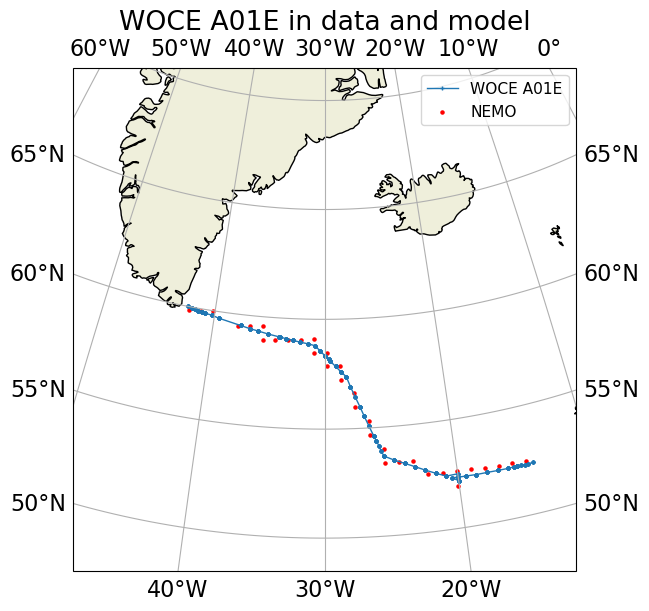

In [31]:
# Describe the model projection in the file
ProjIn = ccrs.PlateCarree (central_longitude=0) 

# Projection for plots
#ProjPlot = ccrs.Robinson (central_longitude=270) # Plotted projection
ProjPlot = ccrs.Orthographic (central_longitude=-30, central_latitude=60) # Plotted projection

# Creates the figure
fig, ax = plt.subplots ( figsize=(15,6), subplot_kw={'projection':ProjPlot}, layout='constrained')

ax.plot    ( lon_data, lat_data, transform=ProjIn, label='WOCE A01E', marker='+', markersize=3, lw=1)
ax.scatter ( lon[section], lat[section], transform=ProjIn, c='red', label='NEMO', s=5 )

width = 0.2 ; ax.set_xlim (-nemo.RA*width, nemo.RA*width) ; ax.set_ylim (-nemo.RA*width, nemo.RA*width)

ax.gridlines (draw_labels=True, crs=ProjIn,)
ax.coastlines ()
ax.add_feature (cartopy.feature.LAND)

ax.set_title ( 'WOCE A01E in data and model' )

ax.legend (fontsize='x-small')

### Compute distance along track

In [32]:
nn = len(lat[section])
dist_a = xr.DataArray (np.zeros_like (lat[section]), dims=('distance',))
dist_a.attrs.update ({'units':'m'})
    
for ji in np.arange(nn-1)+1 : 
    zz =  plotIGCM.sphere.distance ( lat[section][ji-1], lon[section][ji-1], 
                                                lat[section][ji]  , lon[section][ji]  ,
                                                radius=Ra)
    #print ( f'({Ra=} {ji=}, {dist_a[ji-1]=}, {zz=}' )
    dist_a[ji] = dist_a[ji-1] + zz

dist_a = dist_a/1000.0
dist_a.attrs.update ({'units':'km'})
dist_a = dist_a.assign_coords ({'distance':dist_a})

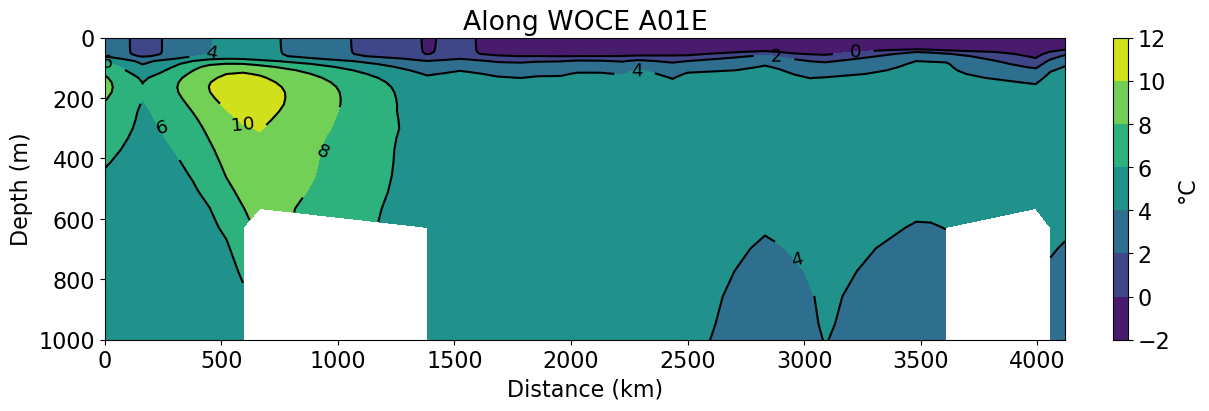

In [33]:
fig, ax = plt.subplots ( figsize=(12,4), layout='constrained')

mcon = ax.contourf (dist_a, depthT, thetao[0,:, section[0], section[1]], cmap=mpl.cm.viridis )
mlin = ax.contour  (dist_a, depthT, thetao[0,:, section[0], section[1]], colors='k' )

# Add labels to contour lines
ax.clabel (mlin, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.0f} '.format, fontsize='small' )

#ax.set_xlim (-45,-10)
ax.set_ylim (0, 1000)

#ax.xaxis.set_major_formatter (cartopy.mpl.ticker.LongitudeFormatter (number_format='.0f'))

ax.set_xlabel ('Distance (km)')
ax.set_ylabel ('Depth (m)')

ax.set_title ('Along WOCE A01E')

plt.colorbar (mcon, label="°C")
             
ax.invert_yaxis ()

## Map

### Robinson

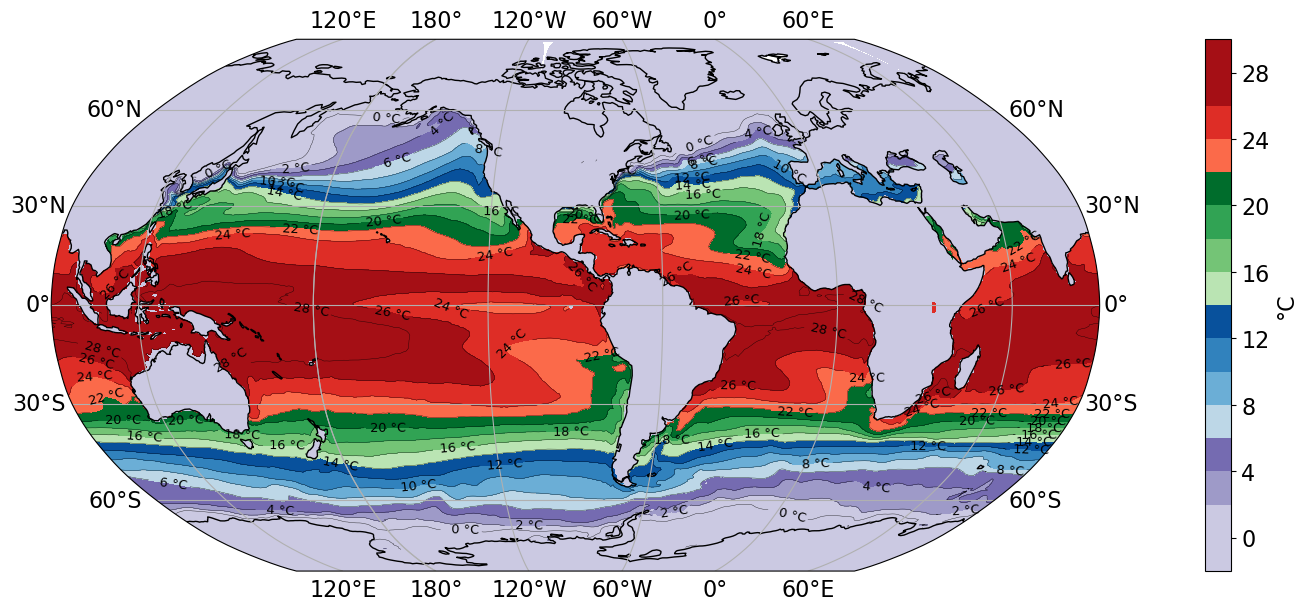

In [34]:
# Creates the color palette
levels = mpl.ticker.MaxNLocator (nbins=16).tick_values (-2, 30)
palet = IPCC.cmap.MultiCat_4
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Describe the model projection in the file
ProjIn = ccrs.PlateCarree (central_longitude=0) 

# Projection for plots
ProjPlot = ccrs.Robinson (central_longitude=270)

# Creates the figure
fig, ax = plt.subplots ( figsize=(15,6), subplot_kw={'projection':ProjPlot}, layout='constrained')
ax.set_global ()

# Select data. We use lbc_plot to have nice plots in any projection
# lbc_plot will set to np.nan the duplicate points at the north pole folding
# It keeps the duplicate points for the east-west periodicity

#t#t = nemo.lbc_plot (thetao[{udims['t']:0, 'z_c':0}], cd_type='T')
tt = thetao[{udims['t']:0, 'z_c':0}]

# Color filing
mmap = ax.contourf (lon, lat, tt, cmap=cmap, levels=levels, transform=ProjIn)
    
# Contour lines
mlin = ax.contour (lon, lat, tt, colors='k', levels=levels, transform=ProjIn, linewidths=0.25)

# Add labels to contour lines
ax.clabel (mlin, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.0f} °C'.format, fontsize='xx-small' )

# Beautify
ax.gridlines (draw_labels=True, crs=ProjIn,)
ax.coastlines ()

plt.colorbar (mmap, label="°C")

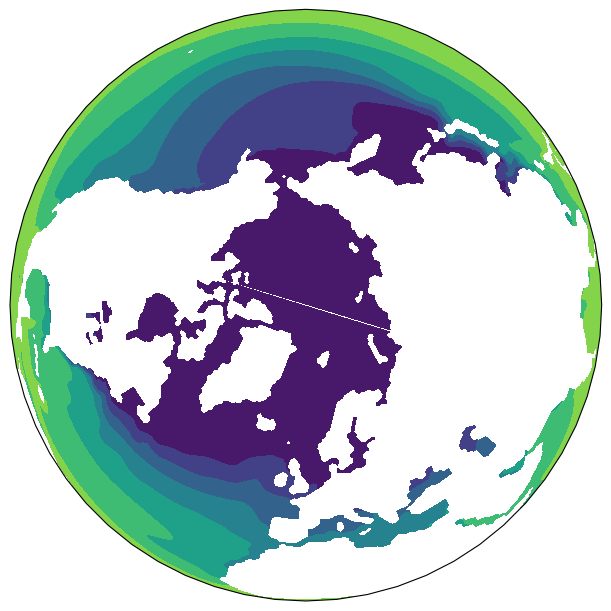

In [35]:
# Describe the model projection in the file
ProjIn = ccrs.PlateCarree (central_longitude=0) 

# Projection for plots
#ProjPlot = ccrs.Robinson (central_longitude=270)
ProjPlot = ccrs.Orthographic (central_latitude=90)

# Creates the figure
fig, ax = plt.subplots ( figsize=(15,6), subplot_kw={'projection':ProjPlot}, layout='constrained')
#ax.set_global ()

tt = thetao[{udims['t']:0, 'z_c':0}]

#ax.contourf ( lon, lat, tt, transform=ProjIn)
#ax.contourf ( lon, lat, nemo.lbc_plot(tt), transform=ProjIn )
#ax.contourf ( lon[:-1], lat[:-1], nemo.lbc     (tt)[:-1], transform=ProjIn )
ax.contourf ( lon[:-1], lat[:-1], nemo.lbc_plot(tt)[:-1], transform=ProjIn )

#ax.contourf ( nemo.lbc_del(lon), nemo.lbc_del(lat), nemo.lbc_del(tt), transform=ProjIn )

#ax.contourf ( lon[:-2, :], lat[:-2, :], tt[:-2, :], transform=ProjIn)

## Orthographic

/Users/marti/miniforge3/envs/PROD/lib/python3.13/site-packages/IPython/core/magics/execution.py:1434: FutureWarning: PYPROJ_GLOBAL_CONTEXT is no longer necessary in pyproj 3.7+ and does not do anything.
  exec(code, glob, local_ns)


CPU times: user 627 ms, sys: 6.39 ms, total: 633 ms
Wall time: 637 ms


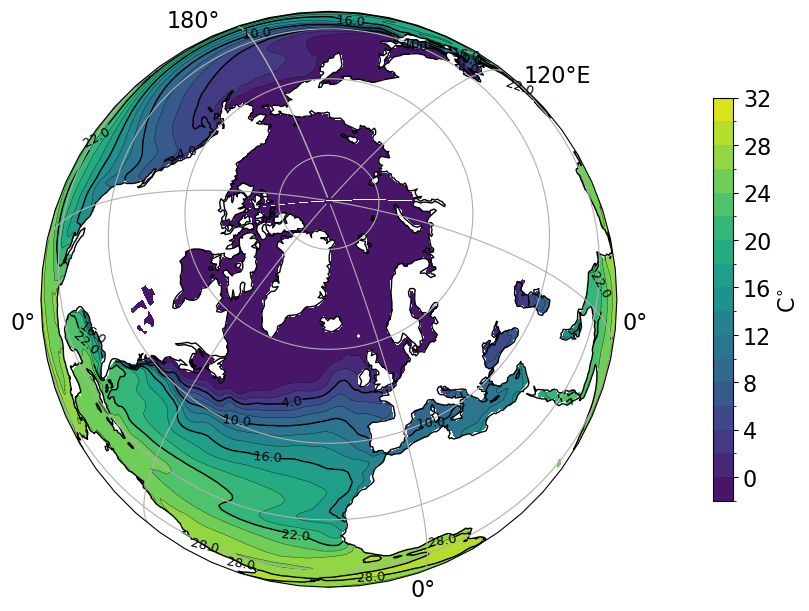

In [36]:
%%time
import cartopy.geodesic
cartopy.geodesic.pyproj.set_use_global_context (active=True)

# Creates the color palette
levels = mpl.ticker.MaxNLocator (nbins=17).tick_values (-2, 32)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Describe the model projection in the file
ProjIn = ccrs.PlateCarree (central_longitude=0) 

# Projection for plots
ProjPlot = ccrs.Orthographic (central_longitude=-20, central_latitude=70)

# Creates the figure
fig = plt.figure (figsize=(15,6), layout='constrained')

# Creates the viewport, with the associated projection
ax = fig.add_subplot (1, 1, 1, projection=ProjPlot)

ax.set_global ()

# Select data. We use lbc_plot to have nice plots in any projection
# lbc_plot will set to np.nan the duplicate points at the north pole folding
# it keeps the duplicate points for the east-west periodicity
tt = nemo.lbc_plot (thetao[{udims['t']:0, 'z_c':0}], cd_type='T')

# Color filing
mmap = ax.contourf (lon, lat, tt, 
                    cmap=cmap, norm=norm, levels=levels, transform=ProjIn,)
    
# Contour lines
mlin3 = ax.contour ( lon, lat, tt, colors='k', levels=levels[::3], transform=ProjIn, linewidths=1)
mlin  = ax.contour ( lon, lat, tt, colors='k', levels=levels, transform=ProjIn, linewidths=0.25)

# Add labels to contour lines
ax.clabel (mlin3, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.1f} '.format, fontsize='xx-small' )

# Beautify
ax.gridlines (draw_labels=True, crs=ProjIn,)
ax.coastlines ()

# Color bar
plt.colorbar (mmap, label=r'C$^{\circ}$', shrink=0.7)

## Plot real coastline of ORCA

### Robinson and polar projections

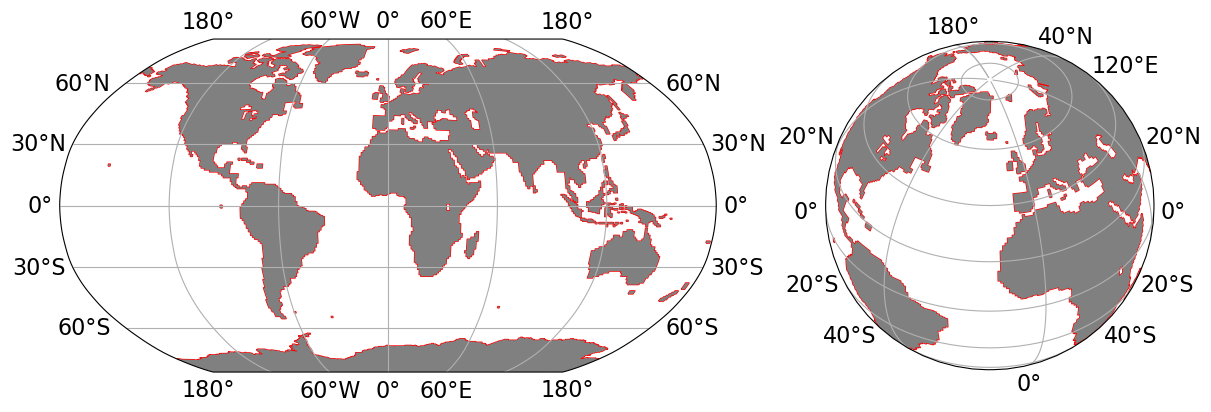

In [37]:
 # Describe the model projection in the file
ProjIn = ccrs.PlateCarree (central_longitude=0) 

### Creates the figure
fig = plt.figure (figsize=(12,5), layout='constrained')
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2,1])

## Robinson projection
## ===================
### Projection for plot
ProjPlot = ccrs.Robinson (central_longitude=0) # Plotted projection
#ProjPlot = ProjIn

### Creates the viewport, with the associated projection
ax = fig.add_subplot (spec[0], projection=ProjPlot)
ax.set_global ()

### Plot real coastline and continent of ORCA
ax.add_feature (coast_poly, facecolor='none' , edgecolor='red')
ax.add_feature (land_poly , facecolor='grey' , edgecolor='none')

ax.gridlines (draw_labels=True, crs=ProjIn)

## Orthographic projection
## ===================
### Projection for plot
ProjPlot = ccrs.Orthographic (central_longitude=-20, central_latitude=40) 

ax = fig.add_subplot ( spec[1], projection=ProjPlot )
ff = 1 ; ax.set_xlim (-Ra*ff, Ra*ff) ; ax.set_ylim (-Ra*ff, Ra*ff)

### Plot real coastline and continents of ORCA
ax.add_feature (coast_poly, facecolor='none' , edgecolor='red'    )
ax.add_feature (land_poly , facecolor='grey', edgecolor='none')

ax.gridlines (draw_labels=True, crs=ProjIn)

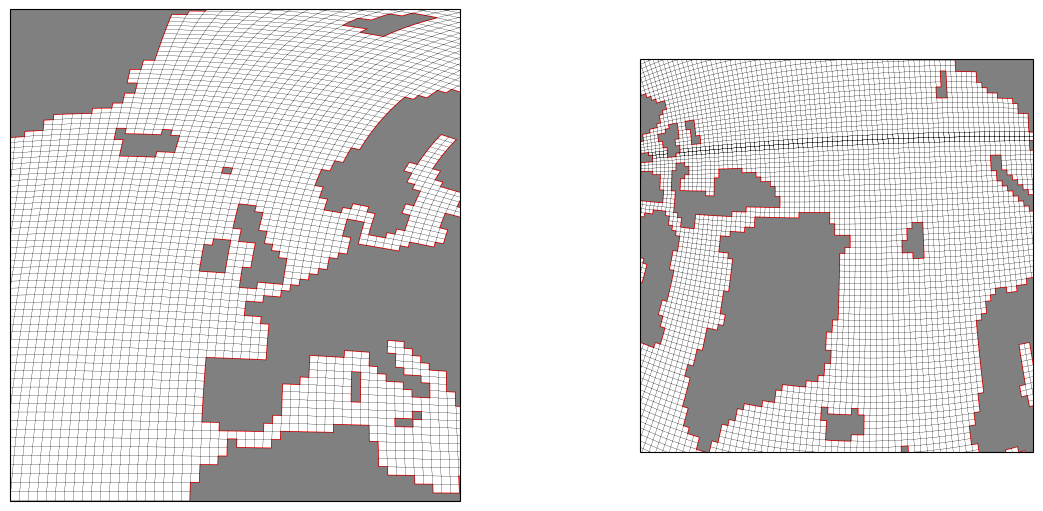

In [50]:
## Plot ORCA grid 

# Describe the model projection in the file
ProjIn = ccrs.PlateCarree (central_longitude=0) 

### Creates the figure
fig = plt.figure (figsize=(12,5), layout='constrained')
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2,1])

## Robinson projection
## ===================
### Projection for plot
ProjPlot = ccrs.Robinson (central_longitude=0) # Plotted projection
#ProjPlot = ProjIn

### Creates the viewport, with the associated projection
ax = fig.add_subplot (spec[0], projection=ProjPlot)
ax.set_extent ([-30, 20, 30, 80])

### Plot real coastline and continent of ORCA
ax.add_feature (coast_poly, facecolor='none', edgecolor='red')
ax.add_feature (land_poly , facecolor='grey', edgecolor='none')
ax.add_feature (grid_poly , facecolor='none', edgecolor='k', lw=0.1)

## Orthographic projection
## ===================
### Projection for plot
ProjPlot = ccrs.Orthographic (central_longitude=-20, central_latitude=80) 

ax = fig.add_subplot ( spec[1], projection=ProjPlot )
ff = 0.3 ; ax.set_xlim (-Ra*ff, Ra*ff) ; ax.set_ylim (-Ra*ff, Ra*ff)

### Plot real coastline and continents of ORCA
ax.add_feature (coast_poly, facecolor='none', edgecolor='red'    )
ax.add_feature (land_poly , facecolor='grey', edgecolor='none')
ax.add_feature (grid_poly , facecolor='none', edgecolor='k', lw=0.1)


## Vertical sections

### Vertical section at Equator

In [ ]:
fig = plt.figure ( figsize=(12, 7), layout="constrained")
#plt.tight_layout ()

# Section of temperature
# ======================
levels = np.arange (10, 32.001, 1)
cmap   = mpl.cm.viridis
colors = cmap (np.linspace (0, 1, len(levels)+1))
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N, clip=False)
ax = fig.add_subplot (2, 2, 1)

# Contour lines
mcon = ax.contour (lon[jeq], depthT, thetao[{udims['t']:0, 'y_c':jeq}], colors=colors, levels=levels, norm=norm)

# Labels contour lines
ax.clabel (mcon, inline=False,  colors='k', # Cut the line where the label will be placed.
        fmt='{:3.1f} '.format, fontsize='xx-small' )

# Plot land masses
ax.pcolor (lon[jeq], depthT, land[:,jeq], cmap='gray', vmin=0, vmax=2, shading='auto')

ax.set_ylim (400,0)
#plt.colorbar (mcon, orientation='vertical', ax=ax, label="°C")
plt.colorbar (mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='°C' )
ax.set_xlabel("Longitude") ; ax.set_ylabel("Depth")
ax.grid(color='k', linestyle='-', linewidth=0.1)
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LongitudeFormatter(number_format='.0f'))

# Section of zonal velocity
# =========================
levels = np.arange (-1.4, 1.4, 0.1)
levels = np.delete (levels, np.where(levels == 0))

cmap   = IPCC.cmap.temp
#colors = cmap (np.linspace (0, 1, len(levels)+1))
#colors[len(levels)//2-1] = [0.98]
#norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N, clip=False)

ax = fig.add_subplot (2, 2, 2)

mmap = ax.contourf (lon[jeq], depthT, uo[{udims['t']:0, 'y_c':jeq}], 
             cmap=cmap, levels=levels)

mcon  = ax.contour (lonU[{'y_c':jeq}], depthT, uo[{udims['t']:0, 'y_c':jeq}], colors='k', levels=levels)

ax.clabel (mcon, inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.1f} '.format, fontsize='xx-small' )

ax.pcolor (lon[{'y_c':jeq}], depthT, land[{'y_c':jeq}], cmap='gray', vmin=0, vmax=2, shading='auto')
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LongitudeFormatter(number_format='.0f'))

ax.set_ylim (400,0)
plt.colorbar (mmap, orientation='vertical', ax=ax, label=r'm$\cdot$ s$^{-1}$')
ax.set_xlabel ("Longitude") ; ax.set_ylabel ("Depth")
ax.grid(color='k', linestyle='-', linewidth=0.1)

# Section of vertical velocity
# ============================
levels = np.arange (-3, 3, 0.5)
levels = np.delete (levels, np.where(levels == 0))
palet  = cmap = IPCC.cmap.precip
colors = palet (np.linspace (0, 1, len(levels)+1))
colors [len(levels)//2+1] = [0.9]
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N, clip=False, extend='both')
ax = fig.add_subplot (2, 2, 3)

# Smoothing vertical velocity
ww = wo[{udims['t']:0}].rolling(z_f=3, y_c=3, x_c=5).mean()[{'y_c':jeq}]*86400

mmap = ax.contourf (lonU[jeq], depthT, ww, colors=colors, norm=norm, levels=levels, extend='both')

mcon  = ax.contour (lonU[{'y_c':jeq}], depthT, ww, colors='k', levels=levels)

ax.pcolor (lon[jeq], depthT, land[:,jeq], cmap='gray', vmin=0, vmax=2, shading='auto')

ax.set_ylim (400,0)
plt.colorbar (mmap, orientation='vertical', ax=ax, label=r"m$\cdot$day$^{-1}$")
ax.set_xlabel("Longitude") ; ax.set_ylabel("Depth")
ax.grid(color='k', linestyle='-', linewidth=0.1)

ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LongitudeFormatter(number_format='.0f'))


### Vertical section accross equator

In [ ]:
fig = plt.figure ( figsize=(12,5), layout="constrained" )

# Section of temperature
# ======================
xcoupe = 80 ; ycoupe = slice (jeq-jpj//3,jeq+jpj//3)
levels = np.arange (-2, 32.1, 2.)
palet  = mpl.cm.mpl.cm.RdYlBu_r
colors = palet (np.linspace ( 0, 1, len(levels)+1) )
norm   = mpl.colors.BoundaryNorm (levels, ncolors=palet.N, clip=False)

ax = fig.add_subplot (2, 2, 1)
mmap = ax.contourf (lat[ycoupe, xcoupe], depthT, thetao[{udims['t']:0, 'y_c':ycoupe, 'x_c':xcoupe}], 
             colors=colors, norm=norm, levels=levels)

mcon = ax.contour (lat[ycoupe, xcoupe], depthT, thetao[{udims['t']:0, 'y_c':ycoupe, 'x_c':xcoupe}], colors='k', levels=levels)

# Add land masses
ax.pcolor (lat[ycoupe, xcoupe], depthT, land[:, ycoupe, xcoupe], cmap='gray', vmin=0, vmax=2, shading='auto')

ax.set_ylim (400,0) ; ax.set_xlim (-50,50)
plt.colorbar (mmap, orientation='vertical', ax=ax, label="°C")
ax.set_xlabel ("Latitude") ; ax.set_ylabel ("Depth")
ax.grid (color='k', linestyle='-', linewidth=0.1)
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter (number_format='.0f'))

print ( "Slice at longitude {:3.1f}".format(lon[{'y_c':jeq, 'x_c':xcoupe}].values ) )

# Section of meridional velocity
# ==============================

levels = [-0.4, -0.3, -0.2, -0.1, -0.05, -0.01, 0.01, 0.05, .1, .2, .3, .4]
cmap   = mpl.cm.RdYlBu_r
colors = cmap (np.linspace (0, 1, len(levels)+1))
colors[len(levels)//2-1] = [0.98]
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N, clip=False, extend='both')
ax = fig.add_subplot (2, 2, 2)

mmap = ax.contourf (lat[ycoupe, xcoupe], depthT, vo[{udims['t']:0, 'y_f':ycoupe, 'x_c':xcoupe}], 
             colors=colors, norm=norm, levels=levels, extend='both')

mcon = ax.contour (lat[ycoupe, xcoupe], depthT, vo[{udims['t']:0, 'y_f':ycoupe, 'x_c':xcoupe}], colors='k', levels=levels)

ax.pcolor (lat[{'y_c':ycoupe, 'x_c':xcoupe}], depthT, land[:, ycoupe, xcoupe], cmap='gray', vmin=0, vmax=2)

ax.set_ylim (400,0) ; ax.set_xlim (-50,50)
plt.colorbar (mmap, orientation='vertical', ax=ax, label=r'm$\cdot$s$^{-1}$')
ax.set_xlabel("Latitude") ; ax.set_ylabel("Depth")
ax.grid(color='k', linestyle='-', linewidth=0.1)
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter (number_format='.0f'))

# Section of zonal velocity
# =========================
levels = [-1.2, -1, -0.8, -0.6, -0.4, -0.2, -0.1, -0.05, -0.02, 0.02, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
cmap   = mpl.cm.RdYlBu_r
colors = cmap (np.linspace (0, 1, len(levels)))
colors[len(levels)//2-1] = [0.98]
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N, clip=False, extend='both')
ax = fig.add_subplot (2, 2, 3)

mmap = ax.contourf (lat[ycoupe, xcoupe], depthT, uo[{udims['t']:0, 'y_c':ycoupe, 'x_f':xcoupe}], 
             colors=colors, norm=norm, levels=levels)

mcon = ax.contour (lat[ycoupe, xcoupe], depthT, uo[{udims['t']:0, 'y_c':ycoupe, 'x_f':xcoupe}], colors='k', levels=levels)

ax.pcolor (lat[{'y_c':ycoupe, 'x_c':xcoupe}], depthT, land[:, ycoupe, xcoupe], cmap='gray', vmin=0, vmax=2, shading='auto')

ax.set_ylim (400, 0) ; ax.set_xlim (-50, 50)
plt.colorbar (mmap, orientation='vertical', ax=ax, label=r'm$\cdot$s$^{-1}$')
ax.set_xlabel("Latitude") ; ax.set_ylabel("Depth")
ax.grid(color='k', linestyle='-', linewidth=0.1)
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter (number_format='.0f'))

# Slice of vertical velocity
# ==========================
levels = [-4, -2, -1, -0.2, -0.1, 0.1, 0.2, 1, 2, 4]
palet  = mpl.cm.RdYlBu_r
colors = palet (np.linspace (0, 1, len(levels)))
colors[len(levels)//2-1] = [0.98]
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N, clip=False, extend='both')
ax = fig.add_subplot (2, 2, 4)

# Smoothing vertical velocity
ww = wo[{udims['t']:0}].rolling(z_f=3, y_c=3, x_c=3).mean()[{'y_c':ycoupe, 'x_c':xcoupe}]*86400

mmap = ax.contourf (lat[ycoupe, xcoupe], depthT, ww, colors=colors, norm=norm, levels=levels, extend='both' )

mcon = ax.contour (lat[{'y_c':ycoupe, 'x_c':xcoupe}], depthT, ww, colors='k', levels=levels)

ax.pcolor (lat[ycoupe, xcoupe], depthT, land[:, ycoupe, xcoupe], cmap='gray', vmin=0, vmax=2, shading='auto')

ax.set_ylim (400, 0) ; ax.set_xlim (-50, 50)
plt.colorbar (mmap, orientation='vertical', ax=ax, label=r'm$\cdot$day$^{-1}$')
ax.set_xlabel ("Latitude") ; ax.set_ylabel ("Depth")
ax.grid (color='k', linestyle='-', linewidth=0.1)

ax.xaxis.set_major_formatter (cartopy.mpl.ticker.LatitudeFormatter (number_format='.0f'))

## Surface currents

In [ ]:
levels = mpl.ticker.MaxNLocator (nbins=10).tick_values (0, 1)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)))
cmap, norm = mpl.colors.from_levels_and_colors (levels, colors, extend='max')

ProjIn   = ccrs.PlateCarree (central_longitude=0)
ProjPlot = ccrs.PlateCarree (central_longitude=0)

fig, ax = plt.subplots ( figsize=(12, 5), subplot_kw={'projection':ProjPlot}, layout="constrained")

# Vector components are averaged at T point
ux = grid.interp (uo.isel({udims['t']:0, 'z_c':0}), "X", boundary="extend")
vy = grid.interp (vo.isel({udims['t']:0, 'z_c':0}), "Y", boundary="extend")
tt = thetao[{udims['t']:0, 'z_c':0}].values
uv = np.sqrt(ux*ux + vy*vy)

ux = ux.where (uv!=0, np.nan)
vy = vy.where (uv!=0, np.nan)
uv = uv.where (uv!=0, np.nan)

mver = ax.quiver (lon.values, lat.values, 
                  ux.values, vy.values, uv.values,
                  pivot='tip', scale=20, width=3E-3, transform=ProjIn,
                  cmap=cmap, norm=norm)
ax.quiverkey (mver, X=0.15, Y=0.1, U=1, color='red', label=r'Velocity : $1 m\cdot s^{-2}$ ', labelpos='N')

ax.contour ( lon, lat, uv, transform=ProjIn, cmap=cmap, norm=norm, linewidths=0.7)

ax.set_extent ( (-60, 10, -10, 10,), crs=ProjIn ) 

ax.coastlines ()
ax.add_feature (cartopy.feature.LAND)

lon_fmt = cartopy.mpl.ticker.LongitudeFormatter(dms=False, number_format='3.0f')
lat_fmt = cartopy.mpl.ticker.LatitudeFormatter (dms=False, number_format='3.1f')
ax.gridlines (draw_labels=True, xformatter=lon_fmt, yformatter=lat_fmt)#, crs=ProjIn)

plt.colorbar (mver, orientation='vertical', ax=fig.axes, label=r'm $\cdot$ s$^{-1}$', shrink=0.7)
#scalebar.scale_bar(ax, location = (0.5,0.15), length=1000, color='red')

## Vertical sections of currents

### Equator section of currents

In [ ]:
fig = plt.figure ( figsize=(12, 5), layout='constrained')

levels = np.arange (0, 1, 0.1)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)))
cmap, norm = mpl.colors.from_levels_and_colors (levels, colors, extend='max')

ax = fig.add_subplot (1, 1, 1)
ax.set_ylim (200,0) ; ax.set_xlim (110-360, 290-360)

# Computes scale factors to get correct direction of vectors
xmin,xmax=ax.get_xlim() ; ymin,ymax=ax.get_ylim()
delta_Y =ax.get_window_extent().height
delta_X =ax.get_window_extent().width

fact_u  = delta_X / np.abs(xmax-xmin) / ( Ra*np.pi/180. )
fact_w  = delta_Y / np.abs(ymax-ymin)

print ( f'{fact_u = } {fact_w = } {fact_w/fact_u = }' )

ux = uo.mean (dim=udims['t'])
wz = wo.mean (dim=udims['t'])

ux = grid.interp (ux, "X", boundary="extend").isel(y_c=jeq)
wz = grid.interp (wz, "Z", boundary="extend").isel(y_c=jeq)

uw = np.sqrt (ux*ux + wz*wz)
ux = ux.where(uw!=0, np.nan)
wz = wz.where(uw!=0, np.nan)

mver = ax.quiver (lon[jeq].values, depthT.values, 
                  ux.values, (wz*fact_w/fact_u).values, uw.values,
                  pivot='tail', scale=50, width=3E-3, cmap=cmap, norm=norm)

ax.pcolor (lon[jeq], depthT, land[:,jeq], cmap='gray', vmin=0, vmax=2)

ax.quiverkey (mver, X=0.1, Y=-0.15, U=1, color='red', label=r'Velocity : 1 $m \cdot s^{-1}$', labelpos='E')

ax.set_xlabel ("Longitude") ; ax.set_ylabel ("Depth (m)")
ax.grid (color='k', linestyle='-', linewidth=0.1)
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LongitudeFormatter(number_format='.0f'))

plt.colorbar (mver, orientation='vertical', ax=fig.axes, label=r'm $\cdot$ s$^{-1}$')

### Section of current accros the equator

In [ ]:
fig = plt.figure ( figsize=(12,5), layout='constrained')
plt.tight_layout () 

# Slice current
xcoupe = int(jpi*0.4) ; ycoupe = slice (jeq-jpj//3,jeq+jpj//3)
levels = np.arange (0, 0.2, 0.02)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)))
cmap, norm = mpl.colors.from_levels_and_colors (levels, colors, extend='max')

ax = fig.add_subplot (1, 1, 1, adjustable='box')
ax.set_ylim (300,0) ; ax.set_xlim (-20, 20)

# Computes scale factors to get correct direction of vectors
xmin,xmax=ax.get_xlim() ; ymin,ymax=ax.get_ylim()
delta_Y = ax.get_window_extent().height
delta_X = ax.get_window_extent().width
fact_v  = delta_X / np.abs(xmax-xmin) / ( Ra*np.pi/180. )
fact_w  = delta_Y / np.abs(ymax-ymin)

#vy = nemo.u2t (vo[:, :, ycoupe, xcoupe].mean(dim=udims['t']), domain=domain)
vy = nemo.lbc (grid.interp (vo.mean(dim=udims['t']), 'Y'))[:, ycoupe, xcoupe]
wz = nemo.lbc (grid.interp (wo.mean(dim=udims['t']), 'Z'))[:, ycoupe, xcoupe]
vw = np.sqrt (vy*vy + wz*wz)
vy = vy.where(vw!=0, np.nan)

mcon = ax.contour (lat[ycoupe, xcoupe], depthT, vy, 
            levels=np.arange(-1,1,0.025), linewidths=2, cmap=cmap) #colors='grey')

ax.clabel (mcon, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt=r'{:3.1f} $m \cdot s^{{-1}}$'.format, 
        fontsize='medium' )

mver = ax.quiver (lat[ycoupe, xcoupe].values, depthT.values, 
                  vy.values, (wz*fact_w/fact_v).values, vw.values,
                  pivot='tail', width=3E-3, 
                  cmap=cmap, norm=norm)

ax.pcolor (lat[ycoupe, xcoupe].values, depthT.values, land[:, ycoupe, xcoupe], 
           cmap='gray', vmin=0, vmax=2)

ax.quiverkey (mver, X=0.1, Y=-0.1, U=0.1, label=r'Velocity : 0.1 m $\cdot$ s$^{-1}$', 
              labelpos='E', color='red', coordinates='axes')

ax.set_xlabel ("Longitude") ; ax.set_ylabel ("Depth")
ax.grid (color='k', linestyle='-', linewidth=0.1)
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter (number_format='.0f'))

plt.colorbar (mver, orientation='vertical', ax=fig.axes, label=r'm $\cdot$ s$^{-1}$')

### Vertical plot with separation depth

Using a vertical transform

In [ ]:
# Transformation functions for the vertical coordinates
depth0= 1000  # Separation depth
zmax  = 5000  # Maximum depth
ratio = 0.5    # Ratio of deep part over surface part
fact = (ratio * depth0 / (zmax - depth0))**0.5
def depth2comp (pz) : return nemo.depth2comp (pz, depth0=depth0, fact=fact)
def comp2depth (pz) : return nemo.comp2depth (pz, depth0=depth0, fact=fact)

fig = plt.figure ( figsize=(13,4), layout='constrained')
ax  = fig.add_subplot (1,1,1)

mmap = ax.contourf ( lon1D, depth2comp(depthT), thetao[0,:,jeq,:] )
mlin = ax.contour  ( lon1D, depth2comp(depthT), thetao[0,:,jeq,:], colors='k' )

ax.set_ylim (depth2comp(zmax), depth2comp(0.5))
ax.set_yscale (mpl.scale.FuncScale (ax, (depth2comp, comp2depth)))

# Ticks
## Longitude ticks
fmtX = cartopy.mpl.ticker.LongitudeFormatter (number_format='.0f')
ax.xaxis.set_major_formatter (fmtX)

## Depth ticks
### Ticks for the upper part
yticks1 = mpl.ticker.MultipleLocator(base= 250.0).tick_values ( 0    , depth0)
### Ticks for the deep part
yticks2 = mpl.ticker.MultipleLocator(base=1000.0).tick_values (depth0, zmax  )
yticks = np.concatenate ( (yticks1[1:-2], [depth0], yticks2[2:-2]))
                                                              
fmtY = '{:.0f}m'.format
ax.set_yticks ( depth2comp (yticks)) ; ax.set_yticklabels ( [fmtY(y) for y in yticks] )

ax.pcolor (lon1D, depth2comp(depthT), land[:,jeq], cmap='grey', vmin=0, vmax=2)

### Plot a line at the separation depth
ax.plot ( ax.get_xlim(), [depth0, depth0], lw=1, color='red', linestyle='dashed')

ax.set_title ('Temperature')
plt.colorbar (mmap, label='°C')

In [ ]:
thetao.sizes

### Vertical vector plot with separation depth

In [ ]:
importlib.reload (nemo) ; domain = nemo.Domain (**domain)
# Transformation functions for the vertical coordinates
depth0= 100    # Separation depth
zmax  = 400    # Maximum depth
ratio = 0.5    # Ratio of deep part over surface part
fact = (ratio * depth0 / (zmax - depth0))**0.5
def depth2comp (pz) : return nemo.depth2comp (pz, depth0=depth0, fact=fact)
def comp2depth (pz) : return nemo.comp2depth (pz, depth0=depth0, fact=fact)

fig = plt.figure ( figsize=(12,4), layout='constrained')
ax  = fig.add_subplot (1,1,1)

#mmap = ax.contourf ( lon1D, depth2comp(depthT), thetao[0,:,jeq,:] )
mlin = ax.contour  ( lon1D, depth2comp(depthT), thetao[0,:,jeq,:], colors='k' )

ax.set_ylim (depth2comp(zmax), depth2comp(0.5))
ax.set_xlim ( -250, -60)

#ax.set_yscale (mpl.scale.FuncScale (ax, (depth2comp, comp2depth)))

print ( ax.get_xlim(), ax.get_ylim())
# Ticks
## Longitude ticks
fmtX = cartopy.mpl.ticker.LongitudeFormatter (number_format='.0f')
ax.xaxis.set_major_formatter (fmtX)

## Depth ticks
### Ticks for the upper part
yticks1 = mpl.ticker.MultipleLocator(base= 50.0).tick_values ( 0    , depth0)
### Ticks for the deep part
yticks2 = mpl.ticker.MultipleLocator(base=100.0).tick_values (depth0, zmax  )
yticks = np.concatenate ( (yticks1[1:-2], [depth0], yticks2[2:-1]))

fmtY = '{:.0f}m'.format
ax.set_yticks ( depth2comp (yticks)) ; ax.set_yticklabels ( [fmtY(y) for y in yticks] )

### Plot a line at the separation depth
ax.plot ( ax.get_xlim(), [depth0, depth0], lw=1, color='red', linestyle='dashed')
print ( f'{ax.get_ylim()=}' )

ax.set_title ('Temperature' )

ux = nemo.lbc (grid.interp (uo, 'X')).isel(y_c=jeq).mean (dim=udims['t'])

wz = grid.interp (wo, 'Z').isel(y_c=jeq).mean (dim=udims['t'])
uw = (ux*ux + wz*wz)**0.5

# Computes scale factors to get correct direction of vectors
xmin,xmax=ax.get_xlim() ; ymin,ymax=ax.get_ylim()
delta_Y = ax.get_window_extent().height
delta_X = ax.get_window_extent().width

fact_c = xr.where ( ux.z_c<depth0, 1./(1.+ratio), ratio/(1.+ratio))
fact_d = xr.where ( ux.z_c<depth0, depth0, zmax-depth0 )

fact_u = delta_X / np.abs(xmax-xmin) / ( Ra*np.pi/180. )
fact_w = delta_Y * fact_c / fact_d

u = ux
w = wz*fact_w/fact_u

mver = ax.quiver (lon[jeq].values, depth2comp(depthT),
                  u.values, w.values,
                  uw.values, pivot='tail', scale=40,
                  width=2E-3)
ax.pcolor (lon[jeq], depthT, land[:,jeq], cmap='gray', vmin=0, vmax=2)

ax.quiverkey (mver, X=0.1, Y=0.15, U=1, color='red', label=r'Velocity : 1 $m \cdot s^{-1}$', labelpos='E')

plt.colorbar (mver, ax=ax, label=r"$m \cdot s^{-1}$")

## Surface currents with a projection

### Computes eastward and northward components of the current 

Velocities are averaged at the T point

#### Compute sinus and cosinus of model's directions with respect to east

In [ ]:
importlib.reload(nemo) ; domain=nemo.Domain(**domain)
gsinT, gcosT = nemo.angle (lon, lat , domain=domain, cd_type='T')

#### Rotate the velocities

In [ ]:
#ue, vn = nemo.rot_uv2en (uo, vo, gsinT, gcosT, domain=domain) 

ut = nemo.lbc (grid.interp (uo, 'X'), domain=domain)
vt = nemo.lbc (grid.interp (vo, 'Y'), domain=domain)

ue = + ut * gcosT - vt * gsinT
vn = + ut * gsinT + vt * gcosT

ue = nemo.lbc (ue, cd_type='T')
vn = nemo.lbc (vn, cd_type='T')

### Plot in Robinson projection

In [ ]:
levels = np.arange (-2, 32.001, 2)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap, norm = mpl.colors.from_levels_and_colors (levels, colors, extend='both')

ProjIn   = ccrs.PlateCarree (central_longitude=0)
ProjPlot = ccrs.Robinson (central_longitude=180)
fig, ax = plt.subplots (figsize=(12,7), subplot_kw={'projection':ProjPlot}, layout="constrained")

ux = ue[{'z_c':0}].mean(dim=udims['t'])
vy = vn[{'z_c':0}].mean(dim=udims['t'])
uv = np.sqrt (ux*ux + vy*vy)
tt = thetao[{'z_c':10}].mean(dim=udims['t'])
ux = ux.where(uv!=0, np.nan)

mver = ax.quiver (lon.values, lat.values, 
                  ux.values, vy.values, tt.values, 
                  pivot='tip', scale=20, 
                  width=1E-3, transform=ProjIn,
                  cmap=cmap, norm=norm)
ax.quiverkey (mver, X=0.06, Y=-0.15, U=1, label=r'Velocity : 1 m $\cdot$ s$^{-1}$', labelpos='S', 
              linewidth=3, color='k')

ax.coastlines ()
ax.add_feature (cartopy.feature.LAND)
ax.gridlines (draw_labels=True, crs=ProjIn)

plt.colorbar (mver, orientation='horizontal', ax=fig.axes, label='°C', shrink=0.4)

In [ ]:
ue.values.shape

## Vectors in polar projection

In [ ]:
ProjIn = ccrs.PlateCarree (central_longitude=0)
ProjPlot = ccrs.Orthographic (central_longitude=270, central_latitude=90)
fig, ax = plt.subplots (figsize=(12,7), subplot_kw={'projection':ProjPlot}, layout='constrained')
#plt.tight_layout()

#levels  = mpl.ticker.MaxNLocator(nbins=19, steps=[1.,  1.5,  2.,  2.5,  5., 10. ]).tick_values(-2,14)
levels = np.linspace ( 27, 35, 17)
palet   = mpl.cm.viridis
colors  = palet (np.linspace(0, 1, len(levels)))
cmap    = mpl.colors.ListedColormap (colors)
norm    = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N)

ux = nemo.lbc_del (ue[{'z_c':0}].mean(dim=udims['t']), domain=domain, cd_type='T', psgn=-1)
vy = nemo.lbc_del (vn[{'z_c':0}].mean(dim=udims['t']), domain=domain, cd_type='T', psgn=-1)
uv = np.sqrt (ux*ux + vy*vy)
ss = nemo.lbc_del ( so[{'z_c':0}].mean(dim=udims['t']) )

# Correct a Cartopy bug in Orthographic projection. See help(nemo.correct_uv) for details
ux, vy = nemo.correct_uv (ux, vy, lat)

ax.contour (lon.values[:-1], lat.values[:-1], nemo.lbc_plot(ss).values[:-1], transform=ProjIn, norm=norm, cmap=cmap, levels=levels) #levels=np.linspace(27,35,20) )

mver = ax.quiver ( nemo.lbc_del(lon).values, nemo.lbc_del(lat).values, ux.values, vy.values, ss.values,
                    pivot='tail', scale=0.9, width=3E-3, transform=ProjIn, norm=norm, cmap=cmap)

width = 0.4 ; ax.set_xlim (-Ra*width, Ra*width) ; ax.set_ylim (-Ra*width, Ra*width)

ax.add_feature (coast_poly, facecolor='grey', edgecolor=foreground, lw=2, zorder=1)

ax.gridlines  (draw_labels=True, crs=ProjIn, zorder=11)

ax.quiverkey (mver, X=0.15, Y=0.05, U=0.05, label=r'Velocity : 5 cm$\cdot$ s$^{-1}$', labelpos='E', 
              linewidth=2, color='red')

plt.colorbar (mver, orientation='vertical', ax=fig.axes, label='PSS', shrink=0.75)

## Streamlines

In [ ]:
ProjIn   = ccrs.PlateCarree (central_longitude=0)
ProjPlot = ccrs.Robinson    (central_longitude=270)
fig = plt.figure (figsize=(12,7), layout='constrained')
ax = fig.add_subplot (1, 1, 1, projection=ProjPlot)

ux = nemo.lbc_plot (ue[{'z_c':0}].mean(dim=udims['t']), domain=domain, cd_type='T', psgn=-1)
vy = nemo.lbc_plot (vn[{'z_c':0}].mean(dim=udims['t']), domain=domain, cd_type='T', psgn=-1)
uv = np.sqrt (ux*ux + vy*vy)
tt = thetao[{'z_c':0}].mean(dim=udims['t'])

col = ax.streamplot (lon.values, lat.values, ux.values, vy.values, transform=ProjIn, density=7, color=tt.values,
                     linewidth=np.minimum (2,uv.values*20) ) 

ax.set_global ()
ax.coastlines ()
ax.gridlines  (draw_labels=True, crs=ProjIn)
ax.add_feature (cartopy.feature.LAND)

plt.colorbar (col.lines, orientation='horizontal', ax=fig.axes, label='°C', shrink=0.7)

## Streamlines in polar projection

In [ ]:
np.seterr (divide='ignore', invalid='ignore')

ProjIn   = ccrs.PlateCarree (central_longitude=0)
ProjPlot = ccrs.Orthographic (central_longitude=270, central_latitude=90)

fig, ax = plt.subplots (figsize=(12,12), subplot_kw={'projection':ProjPlot}, layout='constrained')


width = 0.7 ; ax.set_xlim (-Ra*width, Ra*width) ; ax.set_ylim (-Ra*width, Ra*width)

ux = nemo.lbc ( ue[{'z_c':0}].mean(dim=udims['t']), domain=domain, cd_type='T' )
vy = nemo.lbc ( vn[{'z_c':0}].mean(dim=udims['t']), domain=domain, cd_type='T' )
uv = np.sqrt (ux*ux + vy*vy)
tt = nemo.lbc (thetao[{'z_c':0}].mean(dim=udims['t']),  domain=domain, cd_type='T' )
ss = nemo.lbc (so    [{'z_c':0}].mean(dim=udims['t']),  domain=domain, cd_type='T' )

ux, vy = nemo.correct_uv (ux, vy, lat) # Correct a Cartopy bug in polar projection

jmin=jeq+2 ; jmax = jpj-1
imin, imax = 0, jpi
print ( f'{jmin=}, {jmax=}, {imin=}, {imax=}' )

col = ax.streamplot (lon.values[jmin:jmax,imin:imax], lat.values[jmin:jmax,imin:imax], 
                     ux.values [jmin:jmax,imin:imax], vy.values [jmin:jmax,imin:imax],
                     transform=ProjIn, density=5,
                     color    = ss.values[jmin:jmax,imin:imax],
                     linewidth=np.minimum (2, (uv[jmin:jmax,imin:imax]*50).values), arrowsize=2)

ax.add_feature (coast_poly, facecolor='none', edgecolor=foreground, lw=2, zorder=1)
ax.add_feature (land_poly , facecolor='grey', edgecolor='none', lw=2, zorder=2)

ax.gridlines (draw_labels=True, crs=ProjIn)

plt.colorbar (col.lines, orientation='vertical', ax=fig.axes, label='PSS', shrink=0.5)

## Barotropic stream function (`bsf`)

Barotropic stream function is defined to within one constant. We can define a point `bsf0` where it is 0 (generally in Eurasia).

In [ ]:
lat0=50 ; lon0=90
bsf0 = nemo.find_ji (lat0, lon0, latU, lonU, out='dict')

In [ ]:
bsf = nemo.bsf (uo, e2u*e3u, umask.isel(z_c=0), domain=domain, bsf0=bsf0).mean(dim=udims['t'], keep_attrs=True)
bsf = nemo.lbc_plot (bsf, domain=domain, cd_type='T')

In [ ]:
(bsf*1e-6).min().values, (bsf*1e-6).max().values

In [ ]:
ProjIn   = ccrs.PlateCarree (central_longitude=0) 
ProjPlot = ccrs.Robinson (central_longitude=0) # Plotted projection

# Creates the color palette
cmap = mpl.cm.plasma
#norm = mpl.colors.Normalize ( vmin=bsf.min(), vmax=bsf.max())
levels = np.arange (-80, 220, 10)
# Creates the figure
fig, ax = plt.subplots (figsize=(12,5), subplot_kw={'projection':ProjPlot}, layout='constrained')
ax.set_global ()

mmap = ax.contourf (lon, lat, bsf*1e-6, levels=levels,
                    cmap=cmap, transform=ProjIn)

mlin = ax.contour  (lon, lat, bsf*1e-6, transform=ProjIn, colors='w',
                    levels=levels, linewidths=0.8)

ax.clabel ( mlin, colors='w',
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.0f}'.format, fontsize='small' )

ax.gridlines (draw_labels=True, crs=ProjIn)

ax.add_feature (land_poly , facecolor='black', edgecolor='none', zorder=1)
ax.add_feature (coast_poly, facecolor='none', edgecolor=foreground, zorder=1)

fig.colorbar (mmap, ax=ax, label='Sv' )

## Zonal means

In [ ]:
zotemglo = nemo.zonmean (thetao, bt*  mask, lat1D)
zosalglo = nemo.zonmean (so    , bt*  mask, lat1D)

fig, axs = plt.subplots (1, 2, figsize=(12, 4), layout="constrained")

ax=axs[0]
levels=(27, 33, 33.5, 34, 34.5, 34.6, 34.7, 34.8, 35, 35.5, 36)
mfil = ax.contourf ( zosalglo.lat, zosalglo.z_c, zosalglo.mean(dim=nemo.UDIMS['t']), levels=levels)
mlin = ax.contour  ( zosalglo.lat, zosalglo.z_c, zosalglo.mean(dim=nemo.UDIMS['t']), levels=levels, colors='k' )
ax.clabel (mlin, colors=['k'], manual=False, inline=True,  fmt='{:3.1f} '.format, fontsize='x-small' )

ax.invert_yaxis()
ax.set_xlabel ('Latitude')
ax.set_ylabel ('Depth (m)')
ax.set_title ( 'Zonal mean of salinity')
plt.colorbar (mfil, ax=ax)

ax=axs[1]
mfil = ax.contourf ( zotemglo.lat, zotemglo.z_c, zotemglo[0] )
mlin = ax.contour  ( zotemglo.lat, zotemglo.z_c, zotemglo[0], colors='w' )
ax.clabel (mlin, colors=['w'], manual=False, 
           inline=True,  fmt='{:3.1f} '.format, fontsize='x-small' )

ax.invert_yaxis()
ax.set_xlabel ('Latitude')
ax.set_ylabel ('Depth (m)')
ax.set_title ( 'Zonal mean of temperature')
plt.colorbar (mfil, ax=ax)

## Zonal mean in density coordinates

In [ ]:
rhocoord = np.linspace (21, 28, 100)
rhocoord = xr.DataArray(rhocoord, dims=('rhop',), coords=(rhocoord,))
rhocoord.name='rhop' ; rhocoord.attrs.update ( {'axis':'Z', 'unit':'kg/m3'} )

#rho_grid = xc.regridder.use_use_xgcm.Grid (d_T, coords={'olevel': {'center':'olevel'}}, periodic=False)
so_rho     = grid.transform (so    , 'Z', rhocoord, target_data=rhop-1000.0 )
thetao_rho = grid.transform (thetao, 'Z', rhocoord, target_data=rhop-1000.0 )

zosalglo_rho = nemo.zonmean (so_rho    , e1t*mask, lat1D).mean(dim=nemo.UDIMS['t'])
zotemglo_rho = nemo.zonmean (thetao_rho, e1t*mask, lat1D).mean(dim=nemo.UDIMS['t'])

fig, axs = plt.subplots (1, 2, figsize=(12, 4), layout="constrained")
ax = axs[0]
mfil = ax.contourf (lat1D, rhocoord, zosalglo_rho.T, levels=10)
mlin = ax.contour  (lat1D, rhocoord, zosalglo_rho.T, colors='k', levels=10)
ax.clabel (mlin, colors=['k'], manual=False, inline=True,  fmt='{:3.1f} '.format, fontsize='medium' )

ax.invert_yaxis()
ax.set_xlabel ('Latitude')
ax.set_ylabel (r'$\sigma_{\theta}$ ($kg \cdot m^{-3}$)')
ax.set_title  ('Zonal mean of salinity')
plt.colorbar (mfil, label='PSU', ax=ax)

ax=axs[1]
mfil = ax.contourf (lat1D, rhocoord, zotemglo_rho.T, levels=10)
mlin = ax.contour  (lat1D, rhocoord, zotemglo_rho.T, colors='k', levels=10)
ax.clabel (mlin, colors=['k'], manual=False, inline=True,  fmt='{:3.1f} '.format, fontsize='medium' )

ax.invert_yaxis()
ax.set_xlabel ('Latitude')
ax.set_ylabel (r'$\sigma_{\theta}$ ($kg \cdot m^{-3}$)')
ax.set_title  ('Zonal mean of temperature')
plt.colorbar (mfil, label='°C', ax=ax)


In [ ]:
lat1D, lon1D = nemo.latlon1d (lat, lon)

## Meridional stream functions

### Compute meridional stream functions

In [ ]:
#%%time
zomsfglo = nemo.msf (vo,        e1v*e3v, lat1D, depthW,                  ).mean (dim=udims['t'], keep_attrs=True)
zomsfatl = nemo.msf (vo, atlmsk.values*e1v*e3v, lat1D, depthW, south=-30 ).mean (dim=udims['t'], keep_attrs=True)
zomsfpac = nemo.msf (vo, pacmsk.values*e1v*e3v, lat1D, depthW, south=-30 ).mean (dim=udims['t'], keep_attrs=True)
zomsfind = nemo.msf (vo, indmsk.values*e1v*e3v, lat1D, depthW, south=True).mean (dim=udims['t'], keep_attrs=True)
zomsfipc = nemo.msf (vo, ipcmsk.values*e1v*e3v, lat1D, depthW, south=-30 ).mean (dim=udims['t'], keep_attrs=True)

try :
    zomsfatl_nomed = nemo.msf (vo*atlmsk_nomed.values*e1v*e3v, lat1D, depthW, True)
except : pass

### Plots meridional stream functions

In [ ]:
fig, axs = plt.subplots (3, 2, figsize=(12, 15), layout="constrained", subplot_kw={'visible':False})
axs = axs.ravel()

def msfplot (zmsf, ax, levels = 'auto', land='auto') :
    ax.set_visible (True)
    if levels == 'auto' :
        levels = mpl.ticker.MaxNLocator (nbins=15).tick_values(zmsf.min()*1e-6, zmsf.max()*1e-6)
    palet  = mpl.cm.RdYlGn
    colors = palet (np.linspace(0, 1, len(levels)+1))
    cmap   = mpl.colors.ListedColormap(colors)
    cmap.set_bad ('grey')
    norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')
    
    mmap = ax.contourf (lat1D, depthW, zmsf*1e-6, levels=levels, cmap=cmap, norm=norm, extend='both')
    mlin = ax.contour  (lat1D, depthW, zmsf*1e-6, levels=levels, colors='k')
    
    ax.clabel (mlin, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.0f} '.format, fontsize='medium' )
    
    if np.all (land is not None) : 
        if np.all (land == 'auto') :
            zland = xr.where (np.isnan(zmsf), 1.0, np.nan)
        else : zland = land
        ax.pcolor (lat1D, depthT, zland, cmap='gray', vmin=0, vmax=2, shading='auto')
    
    ax.set_ylim (0, 5200)
    ax.invert_yaxis ()
    ax.set_xlabel ('Latitude') ; ax.set_ylabel ('Depth ($m$)')
    ax.set_xticks ([-60, -30, 0,30, 60])
    ax.xaxis.set_major_formatter (cartopy.mpl.ticker.LatitudeFormatter(number_format='.0f'))
    fig.colorbar (mmap, ax=ax)
    ax.grid()

zland = xr.where (np.isnan(zomsfglo), 1.0, np.nan)

ax = axs[0]
levels = [-50, -20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20, 50]
msfplot (zomsfglo, ax, levels=levels, land=zland)
ax.set_title ('Global')

ax = axs[1]
msfplot (zomsfatl, ax, levels='auto', land=zland)
ax.set_title ('Atlantic')

ax = axs[2]
levels = [-20, -15, -10, -5, -2, -1, 0, 1, 2, 5, 10, 15, 20]
msfplot (zomsfpac, ax, levels=levels, land=zland)
ax.set_title ('Pacific')

ax = axs[3]
levels = [-20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20]
msfplot (zomsfind, ax, levels=levels, land=zland)
ax.set_title ('Indian')

ax = axs[4]
levels = [-20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20]
msfplot (zomsfipc, ax, levels=levels, land=zland)
ax.set_title ('Indian+Pacific')

try : 
    ax = axs[5]
    msfplot (zomsfatl_nomed, ax, levels='auto', land=zland)
    axs.set_title ('Atlantic, no Med')
except : 
    ax.set_visible (False)

### Meridional stream function in density coordinates

Warning : this is probalby not the good way to do it

In [ ]:
fig, axs = plt.subplots (3, 2, figsize=(12, 15), layout="constrained", subplot_kw={'visible':False})
axs = axs.ravel()

zz = nemo.zonmean (rhop, bt, lat1D).mean(dim='time_counter')
rhocoord = np.linspace (1022, 1028, 100)-1000
rhocoord = xr.DataArray ( rhocoord, coords=(rhocoord,), dims=(nemo.UDIMS['z'],))

ds = xr.Dataset ( {'zomsfglo':zomsfglo, 'zomsfatl':zomsfatl, 'zomsfpac':zomsfpac, 'zomsfind':zomsfind, 'zomsfipc':zomsfipc} )

def msfplot_rho (zmsf, ax, levels = 'auto') :
    ax.set_visible ( True)
    rhocoord = np.linspace (1021, 1028, 30)
    rhocoord = xr.DataArray(rhocoord, dims=('rhop',), coords=(rhocoord,))
    zmsf_rho = grid.transform (zmsf, 'Z', rhocoord, target_data=zz)
    
    if levels == 'auto' :
        levels = mpl.ticker.MaxNLocator (nbins=15).tick_values(zmsf_rho.min()*1e-6, zmsf_rho.max()*1e-6)
    palet  = mpl.cm.RdYlGn
    colors = palet (np.linspace(0, 1, len(levels)+1))
    cmap   = mpl.colors.ListedColormap(colors)
    cmap.set_bad ('grey')
    norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')
    
    mmap = ax.contourf (lat1D, rhocoord, zmsf_rho.T*1e-6, levels=levels, cmap=cmap, norm=norm, extend='both')
    mlin = ax.contour  (lat1D, rhocoord, zmsf_rho.T*1e-6, levels=levels, colors='k')
    
    ax.clabel (mlin, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.0f} '.format, fontsize='small' )
        
    ax.invert_yaxis ()
    ax.set_xlabel ('Latitude') ; ax.set_ylabel (r'$\sigma_{\theta} (kg \cdot m^{-3})$')
    ax.set_xticks ([-60, -30, 0,30, 60])
    ax.xaxis.set_major_formatter (cartopy.mpl.ticker.LatitudeFormatter(number_format='.0f'))
    fig.colorbar (mmap, ax=ax, label=r'Sv ($10^6 m^3 \cdot s^{-1}$)')
    ax.grid()

ax = axs[0]
levels = [-50, -20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20, 50]
msfplot_rho (zomsfglo, ax, levels=levels)
ax.set_title ('Global')

ax = axs[1]
msfplot_rho (zomsfatl, ax, levels='auto')
ax.set_title ('Atlantic')

ax = axs[2]
levels = [-20, -15, -10, -5, -2, -1, 0, 1, 2, 5, 10, 15, 20]
msfplot_rho (zomsfpac, ax, levels='auto')
ax.set_title ('Pacific')

ax = axs[3]
levels = [-20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20]
msfplot_rho (zomsfind, ax, levels='auto')
ax.set_title ('Indian')

ax = axs[4]
levels = [-20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20]
msfplot_rho (zomsfipc, ax, levels='auto')
ax.set_title ('Indian+Pacific')

try : 
    ax = axs[5]
    msfplot_rho (zomsfatl_nomed, ax, levels='auto')
    axs.set_title ('Atlantic, no Med')
except : 
    pass

## Streamlines in vertical slices

### Computes velocities at T points

In [ ]:
ut = nemo.lbc (grid.interp (uo, 'X'))
vt = nemo.lbc (grid.interp (vo, 'Y'))

### Create a mask for plotting land masses

In [ ]:
land = xr.where (np.isnan(thetao[{udims['t']:0}]), 1.0, np.nan)

### Interpolate data on regular vertical levels

#### Creates the levels

In [ ]:
dz = thetao.coords['z_c'][1] - thetao.coords['z_c'][0]
std_lev = np.arange (thetao.coords['z_c'][0], 250+dz, dz*0.5)

std_lev = xr.DataArray (std_lev, dims=('std_lev',), coords=(std_lev,))
std_lev.attrs.update ( {'units':'m', 'long_name':'Vertical levels (regular)', 'axis':'Z', 'positive':'down'} )

#### Interpolates
Using xarray fonctionnality, interpolates on regular levels

In [ ]:
ut_std = ut.interp ({'z_c':std_lev}, method="linear")
vt_std = vt.interp ({'z_c':std_lev}, method="linear")
wt_std = wo.interp ({'z_f':std_lev}, method="linear")

## Equator slice of currents

In [ ]:
fig = plt.figure (figsize=(16, 5), layout="constrained")

levels = np.arange (0, 1, 0.1)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)))
cmap, norm = mpl.colors.from_levels_and_colors (levels, colors, extend='max')

ax = fig.add_subplot (1, 1, 1)

ux  = ut_std[{'y_c':jeq}].mean (dim=udims['t'])
wz  = wt_std[{'y_c':jeq}].mean (dim=udims['t'])
uw  = np.sqrt (ux*ux+wz*wz)

lo_min = lon[{'y_c':jeq, 'x_c':0}].values 
dx = (lon[{'y_c':jeq, 'x_c':1}]-lon[{'y_c':jeq, 'x_c':0}]).values
lox = np.arange(jpi)*dx + lo_min
print (lox.shape, lo_min, dx)

X, Y = np.meshgrid (lox, wt_std.std_lev)

ax.set_ylim (250,0)
ax.set_xlim (lox.min(), lox.max())

# Size of plot = size of figure * position in the figure
xmin,xmax=ax.get_xlim() ; ymin,ymax=ax.get_ylim()
Delta_X = fig.get_figwidth ()*np.abs((ax.get_position().xmax-ax.get_position().xmin))
Delta_Y = fig.get_figheight()*np.abs((ax.get_position().ymax-ax.get_position().ymin))

fact_u  = Delta_X / np.abs(xmax-xmin) / ( Ra*np.pi/180. )
fact_w  = Delta_Y / np.abs(ymax-ymin)

mstream = ax.streamplot (X, Y, ux*fact_u, -wz*fact_w, density=3, color=uw.values, 
               linewidth=np.clip (uw.values*5., 0.2, 3),
               arrowsize=2, cmap=cmap, norm=norm) 

ax.pcolor (lon[{'y_c':jeq}], depthT, land[{'y_c':jeq}], cmap='gray', vmin=0, vmax=2, shading='auto')

ax.set_xlabel ("Longitude") ; ax.set_ylabel ("Depth ($m$)")
ax.grid (color='k', linestyle='-', linewidth=0.1)
ax.xaxis.set_major_formatter (cartopy.mpl.ticker.LongitudeFormatter(number_format='.0f'))

plt.colorbar (mstream.lines, orientation='vertical', ax=fig.axes, label=r'$m \cdot s^{-1}$')

## Slice of current accros the equator

In [ ]:
fig = plt.figure (figsize=(16,6), layout="constrained")

# Slice current
xcoupe = 160 
if jeq < 140 : xcoupe = 80
ycoupe = slice (jeq//3, 5*jeq//3)

levels = [0, 0.01, 0.02, 0.05, 0.1, 0.2]
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)))
cmap, norm = mpl.colors.from_levels_and_colors (levels, colors, extend='max')

lat_s = lat[{'x_c':xcoupe, 'y_c':ycoupe}]
vy    = vt_std[{'x_c':xcoupe, 'y_c':ycoupe}].mean(dim=udims['t'])
wz    = wt_std[{'x_c':xcoupe, 'y_c':ycoupe}].mean(dim=udims['t']) 
vw    = np.sqrt (vy*vy+wz*wz)

# Latitude régulière
lat_c = np.linspace ( lat_s.min().item(), lat_s.max().item(), 100)
lat_c = xr.DataArray (lat_c, dims=('lat',), coords=(lat_c,))

vy = vy.assign_coords ({'y_c':lat_s})
wz = wz.assign_coords ({'y_c':lat_s})

vy_c = vy.interp ({'y_c':lat_c.values})
wz_c = wz.interp ({'y_c':lat_c.values})
vw_c = np.sqrt (vy_c*vy_c + wz_c*wz_c)

ax = fig.add_subplot (1, 1, 1, adjustable='box')
ax.set_ylim (200,  0)
ax.set_xlim (-40, 40)

# Facteur de ratio horizontal/vertical
xmin,xmax = ax.get_xlim() ; ymin,ymax=ax.get_ylim()
delta_Y = fig.get_figheight()*np.abs((ax.get_position().ymax-ax.get_position().ymin))
delta_X = fig.get_figwidth ()*np.abs((ax.get_position().xmax-ax.get_position().xmin))
fact_v  = delta_X / np.abs(xmax-xmin) / ( Ra*np.pi/180. )
fact_w  = delta_Y / np.abs(ymax-ymin)

X, Y = np.meshgrid (lat_c.values, vy_c.coords['z_c'].values)

mstream = ax.streamplot (X, Y, (vy_c*fact_v).values, -(wz_c*fact_w).values, density=4,
              color=vw_c.values, 
              linewidth=np.clip (vw_c.values*30., 0.2, 4),
              arrowsize=2, cmap=cmap, norm=norm)

ax.pcolor (lat[{'x_c':xcoupe, 'y_c':ycoupe}].values, depthT.values, land[{'x_c':xcoupe, 'y_c':ycoupe}], 
           cmap='gray', vmin=0, vmax=2)

ax.set_xlabel ("Latitude") ; ax.set_ylabel ("Depth ($m$)")
ax.grid (color='k', linestyle='-', linewidth=0.1)
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter (number_format='.0f'))

plt.colorbar (mstream.lines, orientation='vertical', ax=fig.axes, label=r'$m \cdot s^{-1}$')

## Using 1d lon and lat for simplified and faster plots

In [ ]:
levels = mpl.ticker.MaxNLocator (nbins=17).tick_values (-2, 32)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Creates the figure
fig = plt.figure (figsize=(12,6), layout="constrained")
# Creates the viewport
ax = fig.add_subplot (1, 1, 1)

# Select data
tt = thetao[{udims['t']:0, 'z_c':0}]

# Color filing
mmap = ax.contourf (lon1D, lat1D, tt, cmap=cmap, norm=norm, levels=levels )

# Contour lines
mlin = ax.contour (lon1D, lat1D, tt, colors='k', levels=levels, linewidths=0.25)

# Add labels to contour lines
ax.clabel (mlin, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.1f} '.format, fontsize='xx-small' )

ax.set_xlabel ('Longitude')
ax.xaxis.set_major_formatter (cartopy.mpl.ticker.LongitudeFormatter(number_format='.0f'))

ax.set_ylabel ('Latitude')
ax.yaxis.set_major_formatter (cartopy.mpl.ticker.LatitudeFormatter(number_format='.0f'))

# Color bar
plt.colorbar (mmap, orientation='vertical', shrink=0.75, ax=fig.axes, label="°C")

In [ ]:
levels = mpl.ticker.MaxNLocator (nbins=17).tick_values (-2, 32)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Creates the figure
fig = plt.figure (figsize=(12,6), layout="constrained")
# Creates the viewport
ax = fig.add_subplot (1, 1, 1)

# Select data. 
tt = thetao[{udims['t']:0, 'y_c':jeq}]

# Color filing
mmap = ax.contourf (lon1D, depthT, tt, cmap=cmap, norm=norm, levels=levels )
ax.invert_yaxis()

# Contour lines
mlin = ax.contour (lon1D, depthT, tt, colors='k', levels=levels, linewidths=0.25)

# Add labels to contour lines
ax.clabel (mlin, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.1f} '.format, fontsize='xx-small' )

ax.set_xlabel ('Longitude')
ax.xaxis.set_major_formatter (cartopy.mpl.ticker.LongitudeFormatter(number_format='.0f'))
ax.set_ylabel ("Depth (m)")
ax.grid (color='k', linestyle='-', linewidth=0.1)

# Color bar
plt.colorbar (mmap, orientation='vertical', shrink=0.75, ax=fig.axes, label="°C")

In [ ]:
levels = mpl.ticker.MaxNLocator (nbins=33).tick_values (-0, 30)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Creates the figure
fig = plt.figure (figsize=(12,6), layout="constrained")
# Creates the viewport
ax = fig.add_subplot (1, 1, 1)

# Select data. 
tt = thetao[{udims['t']:0}].mean(dim='x_c')

# Color filing
mmap = ax.contourf (lat1D, depthT, tt, cmap=cmap, norm=norm, levels=levels, extend='both' )
ax.invert_yaxis()

# Contour lines
mlin = ax.contour (lat1D, depthT, tt, colors='k', levels=levels, linewidths=0.25)

# Add labels to contour lines
ax.clabel (mlin, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.1f} '.format, fontsize='xx-small' )

ax.set_xlabel ('Latitude')
ax.xaxis.set_major_formatter (cartopy.mpl.ticker.LatitudeFormatter(number_format='.0f'))
ax.set_ylabel ("Depth (m)")
ax.grid (color='k', linestyle='-', linewidth=0.1)

# Color bar
plt.colorbar (mmap, orientation='vertical', shrink=0.75, ax=fig.axes, label="°C", extend='both')

# To do

## Streamlines in vertical sections. 
The present solution uses an interpolation of the data on a regular grid, as Matplotlib `streamplot` requires a regular grid. Or to understand the use of [transformations](https://matplotlib.org/stable/tutorials/advanced/transforms_tutorial.html) in Matplotlib.


# That's all folks !

In [ ]:
from IPython.display import Image

Bunny = GetLogo ("https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F2f95d3fe-13e7-4220-84b1-9c12d760f233_950x535.jpeg"
, 'Bugs_Bunny.jpeg')

Image (filename='Bugs_Bunny.jpeg', width=400)